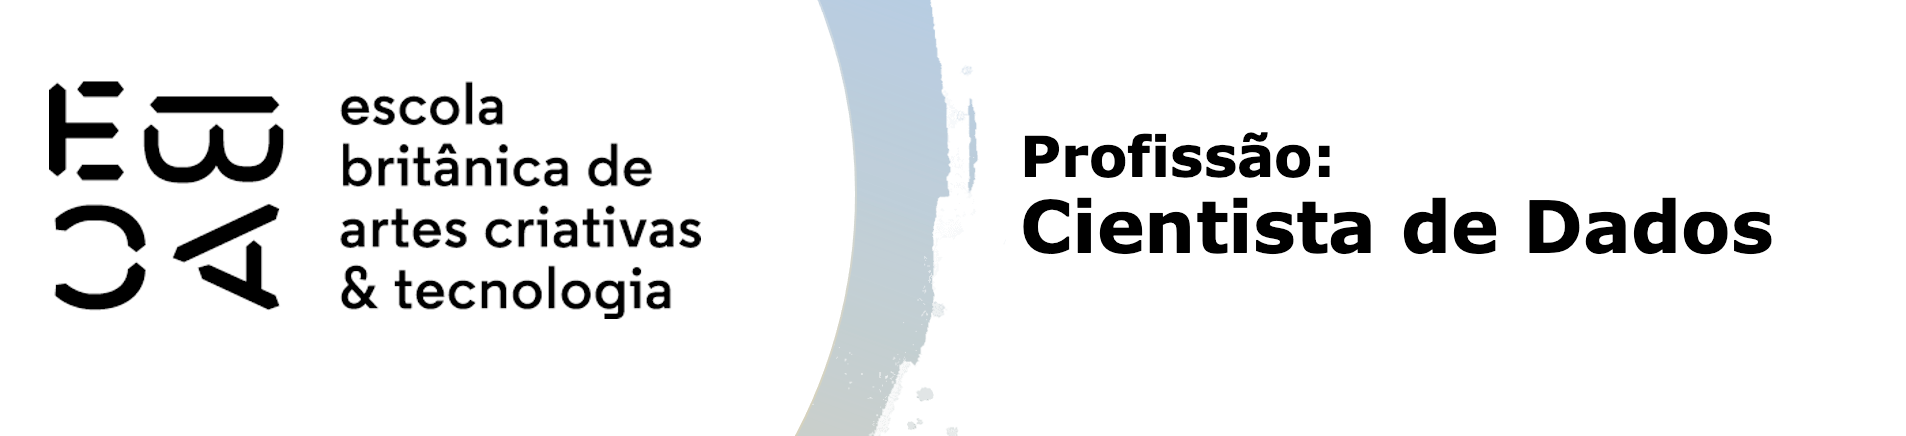

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [410]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter

import seaborn as sns
import numpy as np 

In [73]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [74]:
df_filtro = df[df['Data Emissão'].dt.year > 2019]

In [288]:
proporcao = df_filtro.groupby(['categoria', 'flag_credito']).size().unstack(fill_value=0)
proporcao = proporcao.rename(columns={0: 'nao_evento', 1: 'evento'})
proporcao['total'] = proporcao.evento + proporcao.nao_evento
proporcao['pct_evento'] = proporcao.evento / proporcao.total
proporcao['pct_nao_evento'] = proporcao.nao_evento / proporcao.total
(proporcao[['pct_evento', 'pct_nao_evento']] * 100).round(2).astype(str) + '%'

flag_credito,pct_evento,pct_nao_evento
categoria,,
Alimentos,68.16%,31.84%
Auto posto,25.0%,75.0%
Construção,46.88%,53.12%
Farmácia,35.16%,64.84%
Mercado,47.82%,52.18%
Restaurantes,74.62%,25.38%
Varejo,13.84%,86.16%
Vestuário,23.07%,76.93%
não definido,36.34%,63.66%


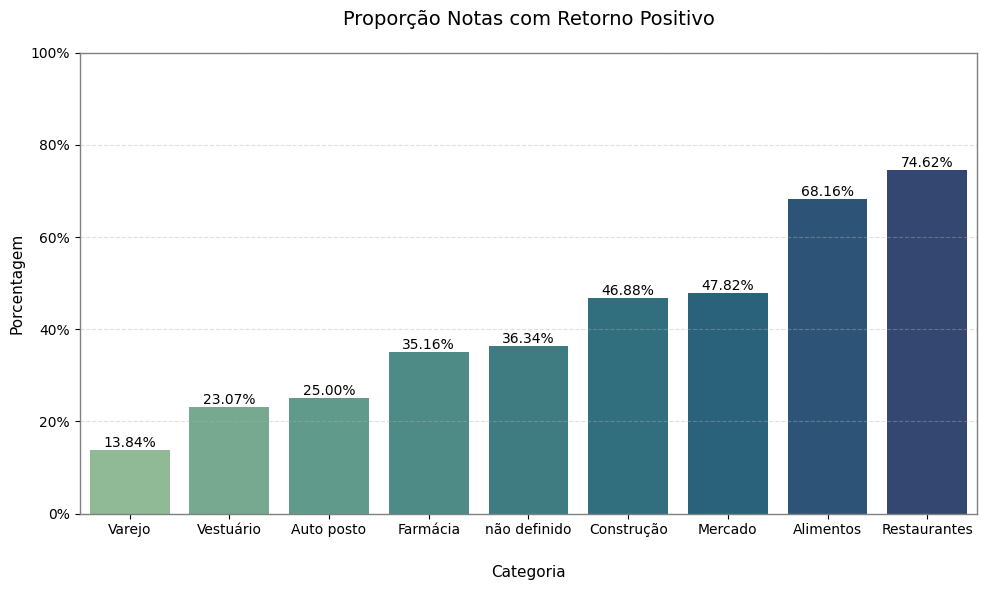

In [300]:
plt.figure(figsize=(10, 6))

grb = proporcao.sort_values(by='pct_evento')
ax = sns.barplot(
                x=grb.index,
                hue=grb.index,
                y=grb.pct_evento,
                palette='crest'
                )   

for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2%}' for v in container.datavalues], fontsize=10)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.set_ylim([0, 1])

ax.tick_params(axis='x')
ax.set_title('Proporção Notas com Retorno Positivo', pad=20, fontsize=14)
ax.set_ylabel('Porcentagem', fontsize=11)
ax.set_xlabel('Categoria', labelpad=20, fontsize=11)
ax.grid(True, linestyle='--', alpha=0.4, axis='y')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('gray')

plt.tight_layout()
plt.show()

As categorias com mais de 50% de chance de ter retorno positivo são `Restaurantes` e `Alimentos`, com 74,62% e 68,16% respectivamente. 

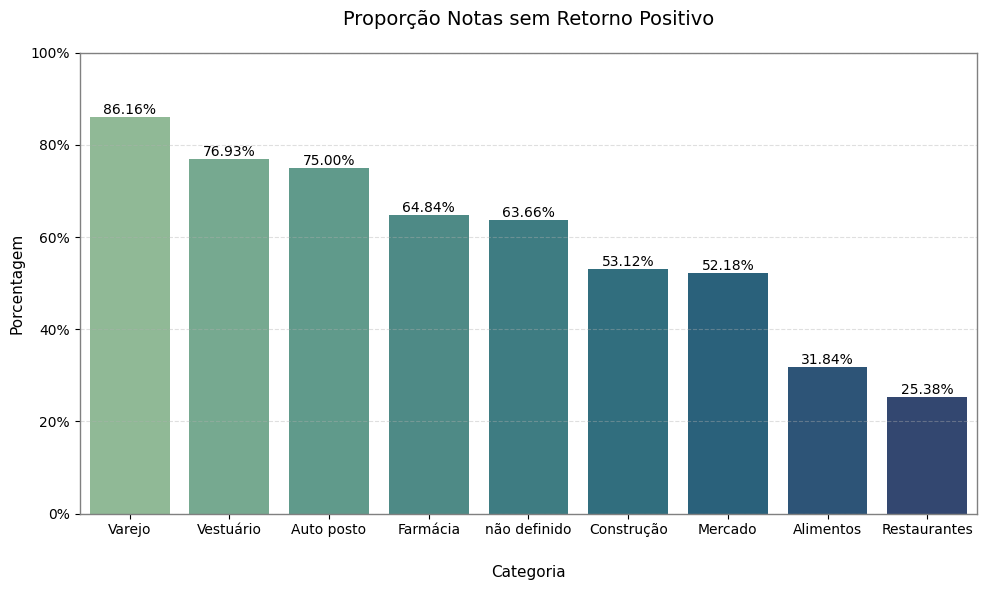

In [301]:
plt.figure(figsize=(10, 6))

grb = proporcao.sort_values(by='pct_nao_evento', ascending=False)
ax = sns.barplot(
                x=grb.index,
                hue=grb.index,
                y=grb.pct_nao_evento,
                palette='crest'
                )   

for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2%}' for v in container.datavalues], fontsize=10)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.set_ylim([0, 1])

ax.tick_params(axis='x')
ax.set_title('Proporção Notas sem Retorno Positivo', pad=20, fontsize=14)
ax.set_ylabel('Porcentagem', fontsize=11)
ax.set_xlabel('Categoria', labelpad=20, fontsize=11)
ax.grid(True, linestyle='--', alpha=0.4, axis='y')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('gray')

plt.tight_layout()
plt.show()

As categorias que tem mais chances de ter uma nota sem retorno positivo são `Varejo` e `Vestuário`, com 86,16% e 76,93% respectivamente.

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [291]:
proporcao['WOE'] = np.log(proporcao.pct_evento/proporcao.pct_nao_evento)
proporcao

flag_credito,nao_evento,evento,total,pct_evento,pct_nao_evento,WOE
categoria,,,,,,
Alimentos,1608,3442,5050,0.681584,0.318416,0.761062
Auto posto,405,135,540,0.250000,0.750000,-1.098612
Construção,8524,7523,16047,0.468810,0.531190,-0.124921
Farmácia,6607,3582,10189,0.351556,0.648444,-0.612208
Mercado,14381,13177,27558,0.478155,0.521845,-0.087435
Restaurantes,553,1626,2179,0.746214,0.253786,1.078520
Varejo,4365,701,5066,0.138373,0.861627,-1.828866
Vestuário,1477,443,1920,0.230729,0.769271,-1.204199
não definido,11718,6689,18407,0.363394,0.636606,-0.560662


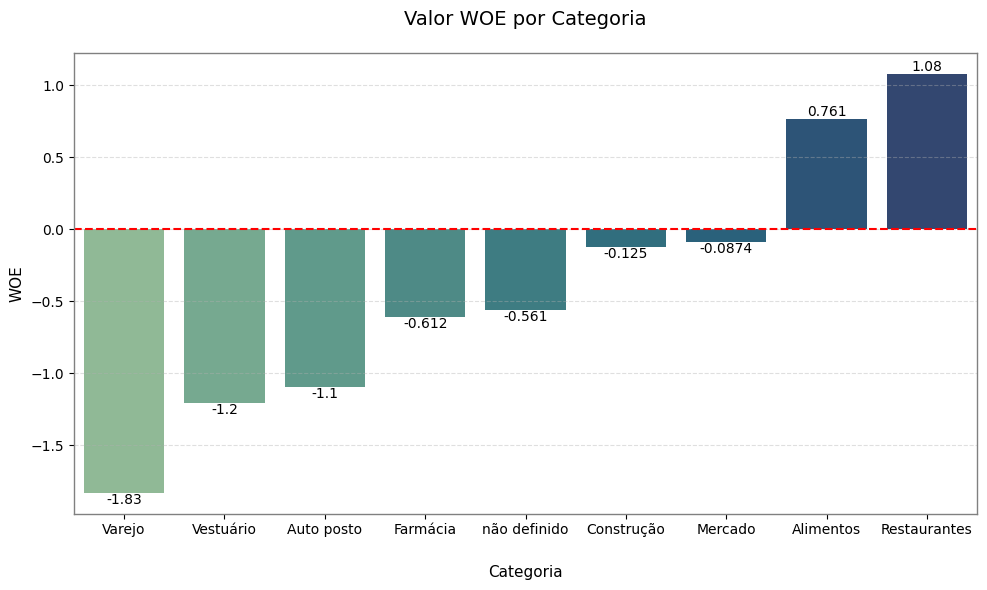

In [302]:
plt.figure(figsize=(10, 6))

grb = proporcao['WOE'].sort_values()
ax = sns.barplot(
                x=grb.index,
                hue=grb.index,
                y=grb.values,
                palette='crest'
                )   

for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.3}' for v in container.datavalues], fontsize=10)

ax.axhline(y=0, linestyle='--', color='r')

ax.tick_params(axis='x')
ax.set_title('Valor WOE por Categoria', pad=20, fontsize=14)
ax.set_ylabel('WOE', fontsize=11)
ax.set_xlabel('Categoria', labelpad=20, fontsize=11)
ax.grid(True, linestyle='--', alpha=0.4, axis='y')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('gray')
    
plt.tight_layout()
plt.show()

As categoria `Varejo`, `Vestuário`, `Auto posto`, `Farmácia` e `não definido` possuem os maiores valores de WOE negativos, o que mostra que essas categorias desfavorecem o evento. As categorias `Construção` e `Mercado` possuem o WOE muito proxímos de zero não distinguindo muito bem o evento, pois tem proporções semelhantes do evento e não evento. Já as categorias `Alimentos`e `Restaurantes` possuem o WOE positivos, favorecento o evento.

### Análise do WOE no tempo:

In [333]:
df_filtro['Data Mes'] = pd.to_datetime(df_filtro['Data Emissão']).dt.to_period('M')

In [334]:
tab = df_filtro.groupby(['Data Mes', 'categoria', 'Retorno Positivo']).size().unstack(fill_value=0).reset_index()
tab = tab.rename(columns={0: 'nao_evento', 1: 'evento'})
tab['total'] = tab.evento + tab.nao_evento
tab['pct_evento'] = tab.evento / tab.total
tab['pct_nao_evento'] = tab.nao_evento / tab.total
tab['WOE'] = np.log(tab.pct_evento/ tab.pct_nao_evento)

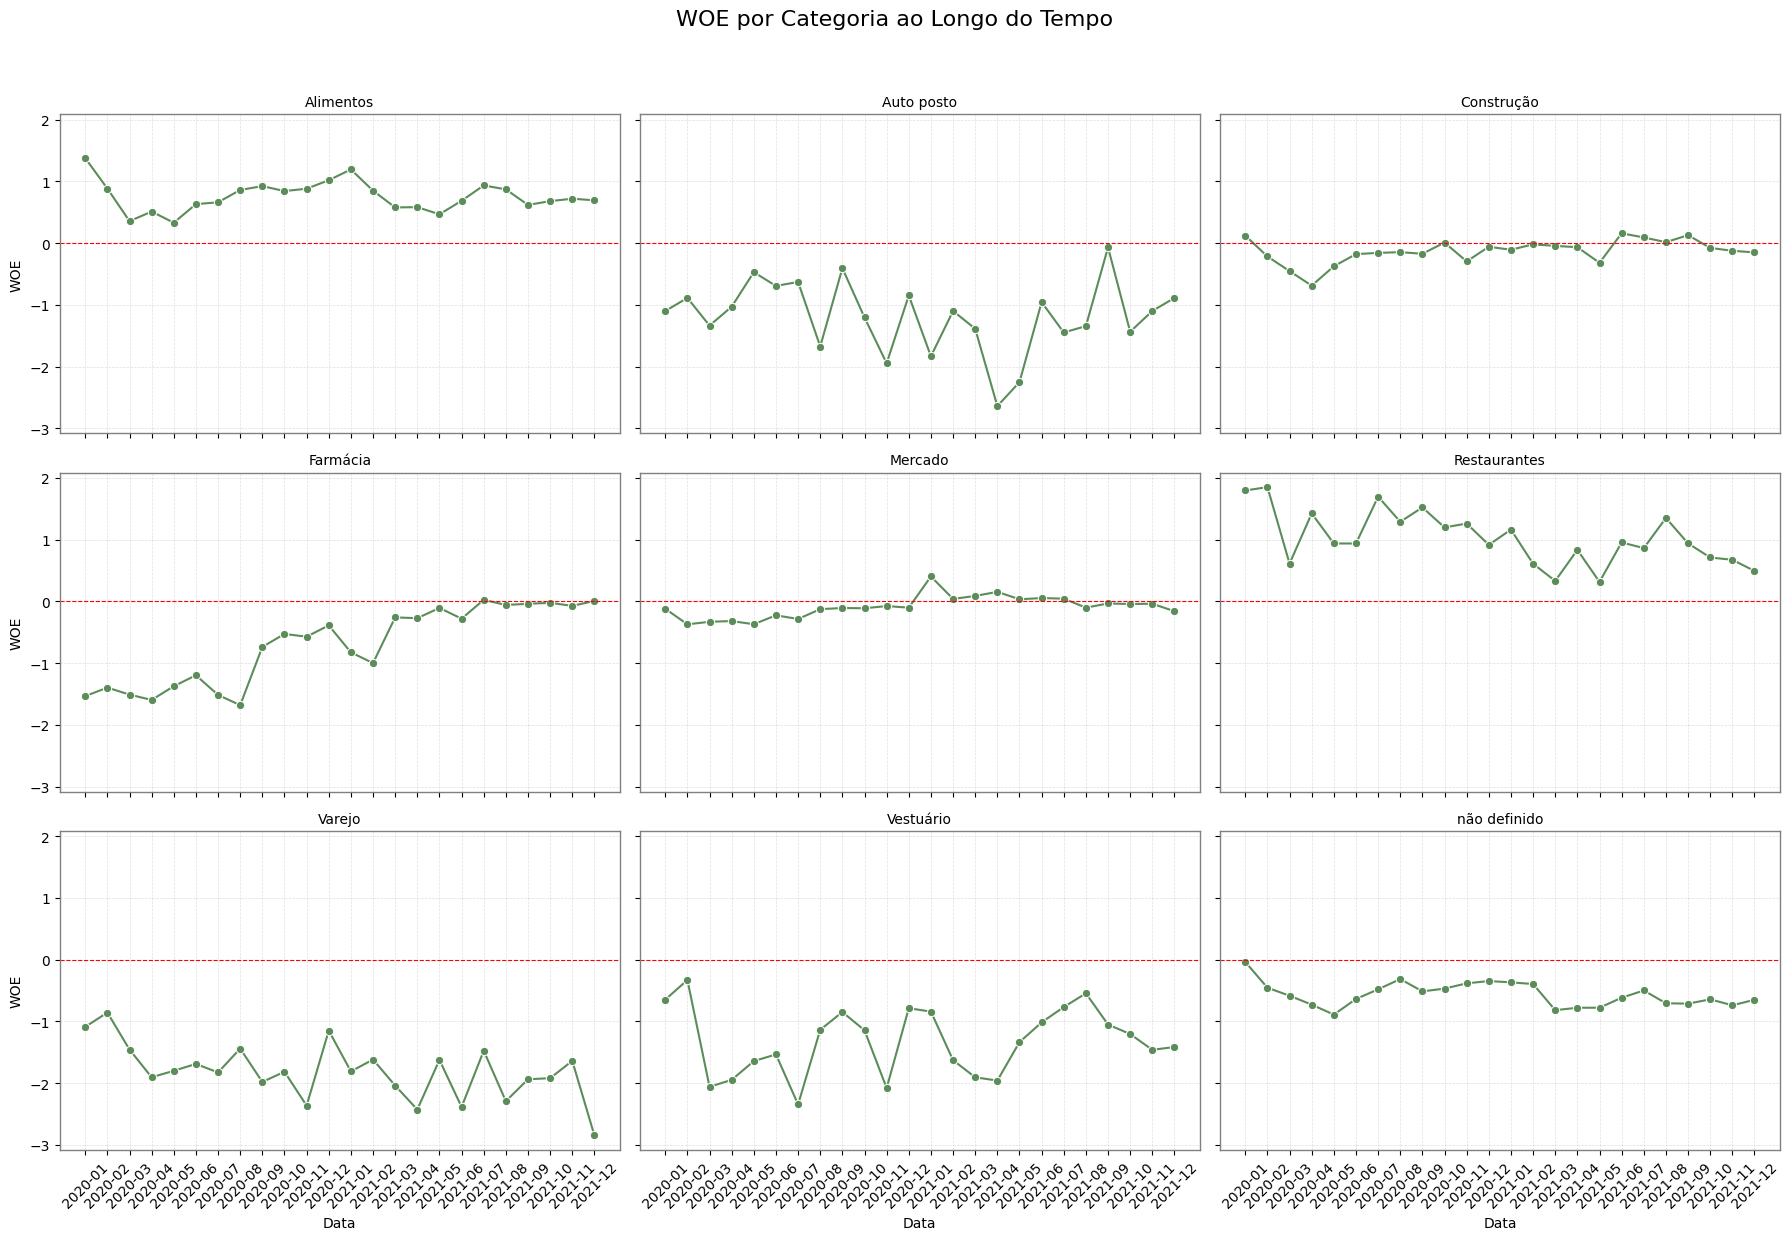

In [335]:
tab['Data Mes'] = tab['Data Mes'].astype(str)

g = sns.FacetGrid(
    data=tab,
    col='categoria',
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=True               
)

g.map_dataframe(sns.lineplot, x='Data Mes', y='WOE', marker='o', color='#5B8C5A')

for ax in g.axes.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(linestyle ='--', color='r', linewidth=0.8)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('gray')

g.set_titles(col_template='{col_name}', fontsize=14)
g.set_axis_labels('Data', 'WOE')
g.fig.suptitle('WOE por Categoria ao Longo do Tempo', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

Durante o periíodo analisado as categorias `Construção` e `Mercado` foram as que mais se mantiveram estaveis, porém sempre muito próximas do zero, dessa forma não sendo capaz de distinguir as chances de ocorrer o evento ou não, o que mostra que a categoria não oferece capacidade preditiva relevante. 

A categoria `Alimentos` apresenta leve instabilidade no tempo, porém com valores sempre positivos. Favorecendo as chances de ocorrer o evento, dessa forma mostrando boa capacidade preditiva.

A categoria `Restaurantes` se mostrou um pouco mais instável no tempo que `Alimentos`, também com valores positivos.

A categoria `não definido` apresenta leve instabilidade no tempo, porém com valores sempre negativos. Já `Farmácia` se mostra um pouco mais instável, com valores saindo do negativo e se aproximando do zero com o passar do tempo.

Já as categorias `Varejo`, `Vestuário` e `Auto posto` são as mais instáveis ao longo do tempo, sempre com valores negativos.

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [327]:
proporcao['IV Parcial'] = (proporcao['pct_evento'] - proporcao['pct_nao_evento'])*proporcao.WOE
proporcao['IV Parcial'].sum()

3.674585958369043

O Information Value para a variável categoria é extremamente elevado, sendo 7,2 vezes maior que o valor ideal de 0,5.

In [328]:
proporcao['IV Parcial']

categoria
Alimentos       0.276393
Auto posto      0.549306
Construção      0.007792
Farmácia        0.181758
Mercado         0.003820
Restaurantes    0.531093
Varejo          1.322733
Vestuário       0.648511
não definido    0.153179
Name: IV Parcial, dtype: float64

### Análise temporal do IV geral da variável categoria:

In [355]:
tab['IV_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.WOE
iv_data = tab.groupby('Data Mes')['IV_parcial'].sum()
iv_data.index = pd.to_datetime(iv_data.index)

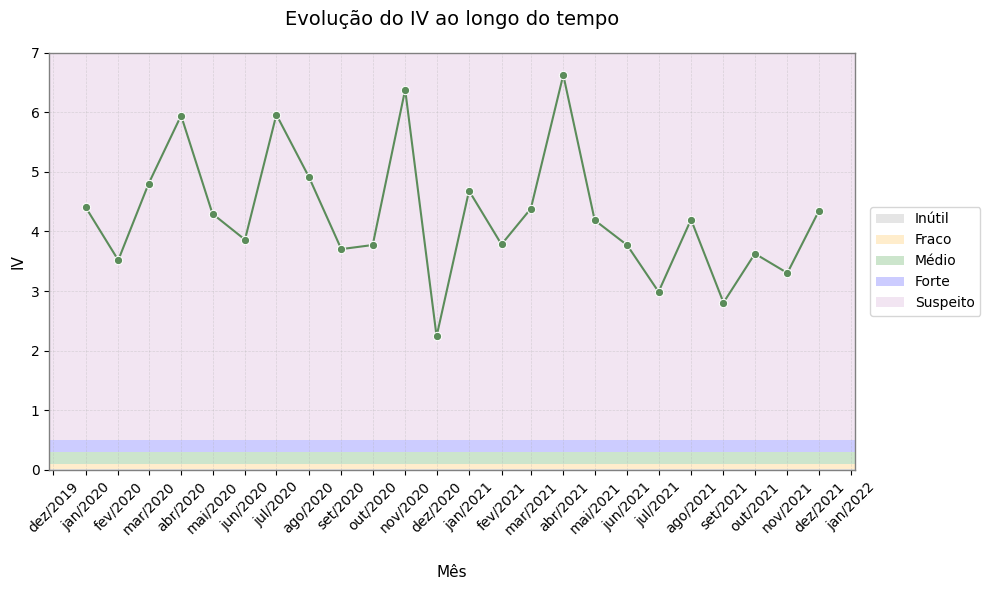

In [ ]:
plt.figure(figsize=(10,6))

ax = sns.lineplot(x=iv_data.index, y=iv_data.values, marker='o', color='#5B8C5A')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.ylim(0,7)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('gray')

ax.axhspan(ymin=0, ymax=0.02, facecolor='gray', label='Inútil', alpha=0.2)
ax.axhspan(ymin=0.02, ymax=0.1, facecolor='orange', label='Fraco', alpha=0.2)
ax.axhspan(ymin=0.1, ymax=0.3, facecolor='green', label='Médio', alpha=0.2)
ax.axhspan(ymin=0.3, ymax=0.5, facecolor='blue', label='Forte', alpha=0.2)
ax.axhspan(ymin=0.5, ymax=7, facecolor='purple', label='Suspeito', alpha=0.1)

ax.tick_params(axis='x', rotation=45)
ax.set_title('Evolução do IV ao longo do tempo', pad=20, fontsize=14)
ax.set_xlabel('Mês', labelpad=20, fontsize=11)
ax.set_ylabel('IV', fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()

### Análise temporal do IV por categoria:

In [419]:
iv_cat = tab.groupby(['Data Mes', 'categoria'])['IV_parcial'].mean().reset_index()

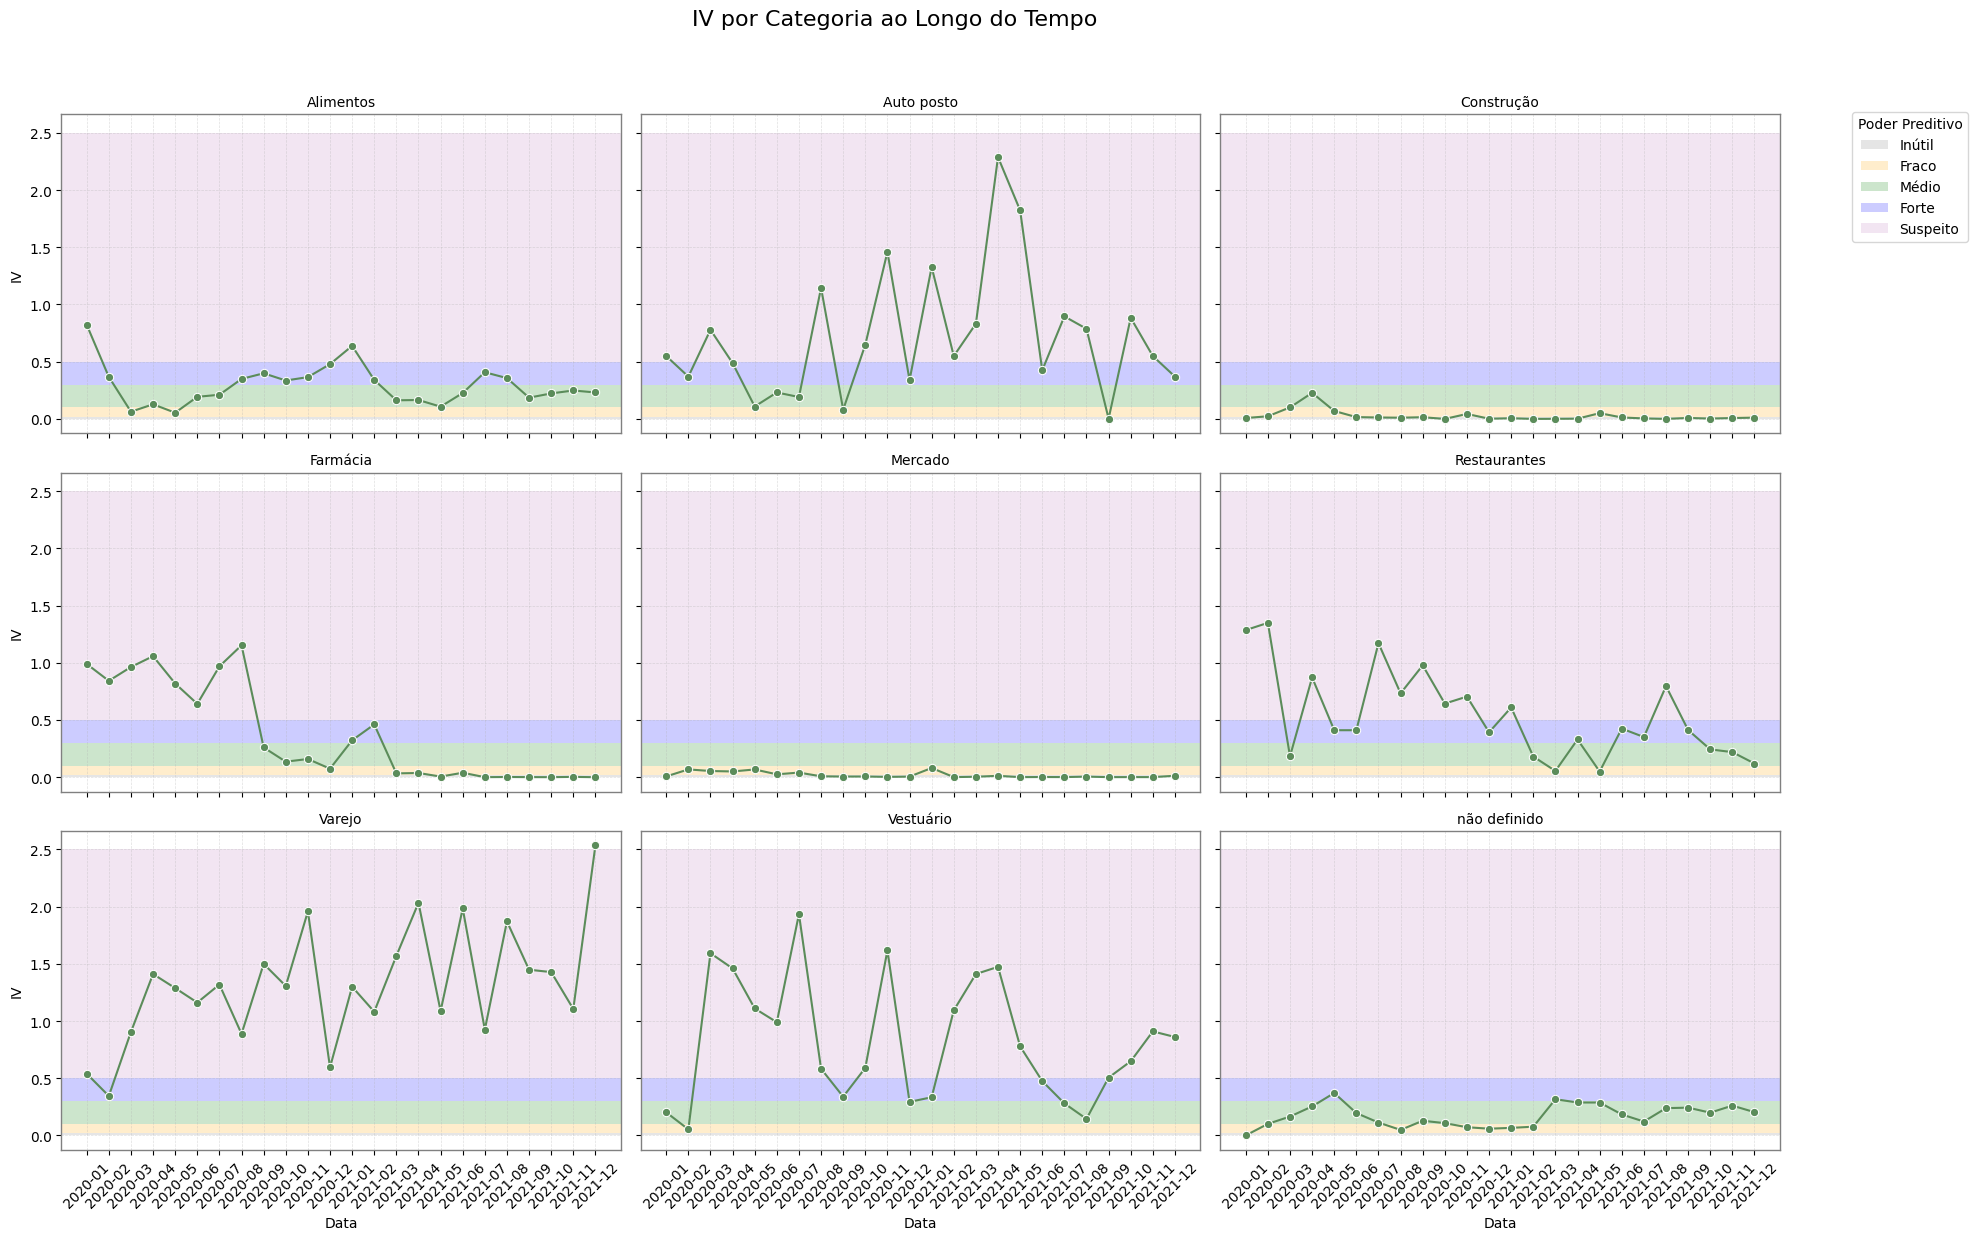

In [420]:
g = sns.FacetGrid(
    data=iv_cat,
    col='categoria',
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=True               
)

g.map_dataframe(sns.lineplot, x='Data Mes', y='IV_parcial', marker='o', color='#5B8C5A')

for ax in g.axes.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
    ax.tick_params(axis='x', rotation=45)
    ax.axhspan(ymin=0, ymax=0.02, facecolor='gray', label='Inútil', alpha=0.2)
    ax.axhspan(ymin=0.02, ymax=0.1, facecolor='orange', label='Fraco', alpha=0.2)
    ax.axhspan(ymin=0.1, ymax=0.3, facecolor='green', label='Médio', alpha=0.2)
    ax.axhspan(ymin=0.3, ymax=0.5, facecolor='blue', label='Forte', alpha=0.2)
    ax.axhspan(ymin=0.5, ymax=2.5, facecolor='purple', label='Suspeito', alpha=0.1)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('gray')

legenda = [
    Patch(facecolor='gray', alpha=0.2, label='Inútil'),
    Patch(facecolor='orange', alpha=0.2, label='Fraco'),
    Patch(facecolor='green', alpha=0.2, label='Médio'),
    Patch(facecolor='blue', alpha=0.2, label='Forte'),
    Patch(facecolor='purple', alpha=0.1, label='Suspeito'),
]

g.set_titles(col_template='{col_name}', fontsize=14)
g.set_axis_labels('Data', 'IV')
g.fig.suptitle('IV por Categoria ao Longo do Tempo', fontsize=16, y=1.03)
g.fig.legend(handles=legenda, loc='upper right', bbox_to_anchor=(1.1, 0.95), title='Poder Preditivo')

plt.tight_layout()
plt.show()

## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


### Análise da Variável `categoria`

A variável `categoria`, em relação à variável `flag_credito`, apresenta relações e características interessantes. Dentre elas, destacam-se:

- A proporção de eventos com crédito positivo se concentra em duas categorias:
  - `Restaurantes`: 74,62%
  - `Alimentos`: 68,16%  
  Essas são as únicas categorias com mais de 50%.

- A proporção de não eventos está mais distribuída entre as categorias:
  - 7 das 9 categorias possuem proporções acima de 50%.
  - `Varejo`: 86,15%
  - `Vestuário`: 76,68%
  - `Auto posto`: 75%

- Como o valor do WOE depende das proporções, observa-se:
  - Apenas as categorias com mais de 50% de eventos com crédito positivo têm WOE > 0.
  - Quanto mais distante de 0, maior a capacidade da categoria em diferenciar eventos de não eventos.

### Análise do WOE por Categoria

- *WOE Positivo*:
  - `Restaurantes`: 1,08
  - `Alimentos`: 0,75  
  Essas categorias são mais propensas ao evento (crédito positivo).

- *WOE Negativo com Alto Módulo*:
  - `Varejo`: -1,83
  - `Vestuário`: -1,20
  - `Auto posto`: -1,10  
  Mais propensas ao não evento (sem crédito) com forte capacidade de diferenciação.

- *WOE Negativo Moderado*:
  - `Farmácia`: -0,61
  - `não definido`: -0,56  
  Também mais propensas ao não evento, porém com menor capacidade de diferenciação.

- *WOE Próximo de Zero*:
  - `Construção`: -0,12
  - `Mercado`: -0,08  
  Baixa capacidade de diferenciação entre evento e não evento.

### Estabilidade Temporal do WOE

- Categorias *mais estáveis*: 
    - `Mercado` e `Construção` (mas com WOE próximo de zero).

- Categorias *mais propensas ao evento*:
  - `Alimentos`: mais estável
  - `Restaurantes`: menos estável

- Categorias *mais propensas ao não evento*:
  - `Auto posto`: mais instável
  - `Vestuário` e `Varejo`: também instáveis

- Categorias com leve diferenciação:
  - `não definido`: estabilidade razoável
  - `Farmácia`: comportamento crescente (WOE se aproxima de zero ao longo do tempo)

### Information Value (IV)

- O *IV total* da variável categoria é de *3,67*  
  Valor extremamente alto — mais de 7 vezes o ideal de 0,5, indicando alto risco de overfitting.

- Algumas categorias com IV abaixo do limite ideal de 0,5:
  - `Farmácia`: 0,17
  - `não definido`: 0,14
  - `Alimentos`: 0,28
  - `Restaurantes`: 0,52
  - `Auto posto`: 0,55

### Estabilidade temporal do IV:

- Mais estáveis: 
    - `Alimentos` e `não definido`
- Menos estáveis: 
    - `Restaurantes` e `Auto posto`
    - `Farmácia`: leve instabilidade; IV geral é médio, mas chega a "suspeito" antes de 07/2020

### Conclusão Final

A variável categoria carrega alto risco de overfitting devido ao IV total elevado. No entanto, com análise cuidadosa por categoria, é possível realizar uma *seleção criteriosa*:

- ✅ *Selecionar Alimentos*:
  - Proporção de eventos: 68,16%
  - WOE: 0,75
  - IV: 0,28 (poder preditivo médio)
  - Estabilidade temporal razoável

- ✅ *Selecionar não definido*:
  - Proporção de não eventos: 63,66%
  - WOE: -0,56
  - IV: 0,14 (poder preditivo médio)
  - Boa estabilidade temporal